In [1]:
import pickle
with open('sup_loaded_data.pickle', 'rb') as f:
    sup_DATA = pickle.load(f) 

In [2]:
len(sup_DATA[1]['MFCCS'])

3315

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

Using TensorFlow backend.


In [74]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img = np.log(img + 1e-9)
#             img = librosa.util.normalize(img)
            X[i,] = img / self.scale
            X[i,] = img 

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
    def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
        self.features   = data_x
        self.labels     = data_y
        self.batch_size = 48
        self.shuffle    = shuffle
        self.n_features = self.features.shape[1]
        self.n_classes  = 1
        self.on_epoch_end()

    def __len__(self):
        
        return int(np.floor(len(self.features) / self.batch_size))

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.features))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
 
    def __data_generation(self,indexes):
        X = np.empty((self.batch_size, self.n_features))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(indexes):
            X[i,] = self.features[ID]
            y[i,] = self.labels[ID]
        return X, y
    
class specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, Y, batch_size,target_size=(64,64)):
        self.genX2 = CustomDataset(X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, Y_batch = self.genX2.__getitem__(index)
        return X_batch, Y_batch
    
# class MultipleInputGenerator(keras.utils.Sequence):
#     """Wrapper of two generatos for the combined input model"""

#     def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
#         self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
#         self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

#     def __len__(self):
#         return self.genX1.__len__()

#     def __getitem__(self, index):
#         X1_batch, Y_batch = self.genX1.__getitem__(index)
#         X2_batch, Y_batch = self.genX2.__getitem__(index)
#         X_batch = [X1_batch, X2_batch]
#         return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
        self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
        self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
        self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
        
    def __len__(self):

        return self.genX1.__len__()
    
    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)
        X2_batch, Y_batch = self.genX2.__getitem__(index)
        X3_batch, Y_batch = self.genX3.__getitem__(index)
        X_batch = [X1_batch, X2_batch, X3_batch]
        return X_batch, Y_batch

In [75]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

class Evaluation(Callback):
    def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
        super(Evaluation, self).__init__()
        self.test_data = test_data_gen
        self.val_labels = val_labels
        self.val_data = val_data_gen
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        y_preds = self.model.predict_generator(self.val_data)
        print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

        y_preds = self.model.predict_generator(self.test_data)
        print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [80]:
def build_model():
    '''Function to build ensemble model'''
#     # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,3))
    lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.3)(lay14_)
#     # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

#     # merge input models
#     merge = concatenate([lay15_, lay4,lay43])

#     # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
#     hidden2 = Dense(64, activation='relu')(hidden1)
    output  = Dense(1, activation='sigmoid')(lay15_)
    MERGM   = Model(inputs=inp2, outputs=output)

    return MERGM

In [81]:
def ResNetSimCLR(base_model='resnet18'):
    inputs = tf.keras.layers.Input(shape=(64,64,3))

    base_encoder = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None,
                                                  input_shape=None, pooling='avg')
    base_encoder.training = True
    h = base_encoder(inputs)

    # projection head
    x = tf.keras.layers.Dense(256)(h)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    output  = Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [78]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)

class_weights

array([0.66475645, 2.0173913 ])

In [100]:
# Create directory to save models
rt_sv_dir = './supervised_normalization'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
NUM_shuf= 1

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    with tf.device("/gpu:0"):
        MERGM = build_model()

        Adam = tf.keras.optimizers.Adam(0.005)

        MERGM.compile(
          optimizer = Adam,
          loss = 'BinaryCrossentropy',
          metrics=['AUC'])

        tfeatures = sup_DATA[RUN]['MFCCS'][:int(0.7*3315)]
        textra    = sup_DATA[RUN]['EXTRA'][:int(0.7*3315)]
        timgs     = sup_DATA[RUN]['MEL'][:int(0.7*3315)]
        labels    = sup_DATA[RUN]['LABELS'][:int(0.7*3315)]

        test_features= sup_DATA[RUN]['MFCCS'][ int(0.7*3315): int(0.85*3315)]
        test_extra   = sup_DATA[RUN]['EXTRA'][ int(0.7*3315): int(0.85*3315)]
        test_imgs    = sup_DATA[RUN]['MEL'][ int(0.7*3315): int(0.85*3315)]
        test_labels  = sup_DATA[RUN]['LABELS'][ int(0.7*3315): int(0.85*3315)]

        val_features= sup_DATA[RUN]['MFCCS'][ int(0.85*3315) :]
        val_extra   = sup_DATA[RUN]['EXTRA'][ int(0.85*3315) :]
        val_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*3315) :]
        val_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*3315) :]

        imgs_em      = specGenerator(timgs,labels,batch_size=32,target_size=(64,64))
        TEST          = specGenerator(test_imgs,test_labels,batch_size=32,target_size=(64,64))
        VAL         = specGenerator(val_imgs,val_labels,batch_size=32,target_size=(64,64))


        evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                    "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
        os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
#         class_weight = {0: 0.6621, 1:2.0422}
        tf.random.set_seed(4)
        history = MERGM.fit_generator(
                      imgs_em,
                      epochs=30,
                      validation_data=VAL, 
                      verbose=2, 
                      callbacks=[evaluator, checkpointer])
        historys[RUN]=history.history

        MERGM_Record1 = MERGM.evaluate_generator(
        TEST
        )
        print()
        print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

        print()
        from sklearn.metrics import roc_auc_score

        y_val  = val_labels
        y_preds_val = MERGM.predict_generator(VAL)
        print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

        y_test  = test_labels
        y_preds_test = MERGM.predict(TEST)
        print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
        print()
        print('-----------------------------------------------------------------')

Epoch 1/30
 | val_auc: 0.573974609375
 | test_auc: 0.5066915655150949
72/72 - 9s - loss: 0.6817 - auc: 0.5133 - val_loss: 0.5728 - val_auc: 0.5740
Epoch 2/30
 | val_auc: 0.6151012073863636
 | test_auc: 0.5839298682435937
72/72 - 9s - loss: 0.5510 - auc: 0.6052 - val_loss: 0.5675 - val_auc: 0.6152
Epoch 3/30
 | val_auc: 0.6189630681818182
 | test_auc: 0.5770308123249299
72/72 - 9s - loss: 0.5602 - auc: 0.5941 - val_loss: 0.5559 - val_auc: 0.6184
Epoch 4/30
 | val_auc: 0.6104847301136365
 | test_auc: 0.5363886295258844
72/72 - 9s - loss: 0.5366 - auc: 0.6439 - val_loss: 0.6719 - val_auc: 0.6107
Epoch 5/30
 | val_auc: 0.6672141335227273
 | test_auc: 0.6600010374520179
72/72 - 9s - loss: 0.5306 - auc: 0.6650 - val_loss: 0.5877 - val_auc: 0.6650
Epoch 6/30
 | val_auc: 0.61767578125
 | test_auc: 0.6153906006847183
72/72 - 9s - loss: 0.5321 - auc: 0.6593 - val_loss: 0.5634 - val_auc: 0.6171
Epoch 7/30
 | val_auc: 0.6593350497159092
 | test_auc: 0.6807111733582321
72/72 - 9s - loss: 0.5320 - a

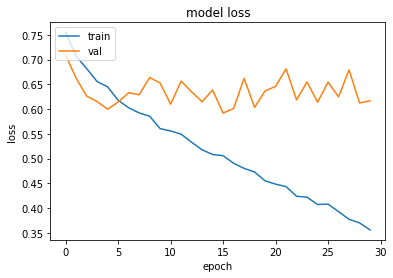

In [89]:
import matplotlib.pyplot as plt
plt.plot(historys[0]['loss'])
plt.plot(historys[0]['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: './model_1/0/*.hdf5',
          1: './model_1/1/*.hdf5',
          2: './model_1/2/*.hdf5',
          3: './model_1/3/*.hdf5',
          4: './model_1/4/*.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(3):
    test_features= sup_DATA[iii]['MFCCS'][ int(0.7*3315): int(0.85*3315)]
    test_extra   = sup_DATA[iii]['EXTRA'][ int(0.7*3315): int(0.85*3315)]
    test_imgs    = sup_DATA[iii]['MEL'][ int(0.7*3315): int(0.85*3315)]
    test_labels  = sup_DATA[iii]['LABELS'][ int(0.7*3315): int(0.85*3315)]
    TEST         = specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
    path = './model_1/0'
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./supervised_class_weight/4/030--0.614--0.564.hdf5")
    y_score = model.predict(TEST)
    fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
    print('Num_samples:', len(y_score))
    print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.7))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

NameError: name 'average_precision_score' is not defined

In [30]:
def to_one_or_zero(bool):
    return 1 if bool else 0

In [45]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

for iii in range(3):
    print(iii)
    test_features= sup_DATA[iii]['MFCCS'][ int(0.7*3315): int(0.85*3315)]
    test_extra   = sup_DATA[iii]['EXTRA'][ int(0.7*3315): int(0.85*3315)]
    test_imgs    = sup_DATA[iii]['MEL'][ int(0.7*3315): int(0.85*3315)]
    test_labels  = sup_DATA[iii]['LABELS'][ int(0.7*3315): int(0.85*3315)]
    TEST         = specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./supervised_class_weight/4/030--0.614--0.564.hdf5")
    y_score = model.predict(TEST)
    y_score = list(map(to_one_or_zero, y_score > .6))
 
    con_mat = tf.math.confusion_matrix(labels=test_labels[:len(y_score)], predictions=y_score).numpy()
    print(con_mat)
#     con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
#     con_mat_df = pd.DataFrame(con_mat_norm,
#                      index = 2, 
#                      columns = [0,1])
#     print(con_mat_df)
#     figure = plt.figure(figsize=(8, 8))
#     sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

0
[[341  37]
 [ 41  61]]
1
[[309  49]
 [ 59  63]]
2
[[312  47]
 [ 52  69]]


In [49]:
positive=0
negetive=0

for i in labels:
    if i == 0:
        negetive +=1
    else:
        positive +=1
print('negetive:',negetive)
print('positive:',positive)

negetive: 1749
positive: 571
